# Convert ZEMAX ray trace file into coordinates document

TOP LEVEL A+ ZEMAX layout: https://dcc.ligo.org/LIGO-E1900255
- Data comes from: LHO HAM6 https://dcc.ligo.org/E2100383-v4

## Import the data

In [1]:
# import SCHTUFF
import pandas as pd
import numpy as np
IFOname = 'LHO'

Find the encoding

In [2]:
fname = 'LHO_zemax_HAM6.txt'
import chardet
with open(fname, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large
print('Encoding is ', result['encoding'])

Encoding is  UTF-16


Find the first line of the table

In [3]:
# string to search in file
with open(r'LHO_zemax_HAM6.txt', 'r', encoding=result['encoding']) as fp:
    # read all lines using readline()
    lines = fp.readlines()
    for row in lines:
        # check if string present on a current line
        word = 'Seg#'
        #print(row.find(word))
        # find() method returns -1 if the value is not found,
        # if found it returns index of the first occurrence of the substring
        if row.find(word) != -1:
            print('string exists in file')
            print('line Number:', lines.index(row))
            tableStart = lines.index(row)

string exists in file
line Number: 13


Read the table - skipping the header material

In [4]:
df = pd.read_table(fname, encoding=result['encoding'], skiprows=tableStart)

## Manipulate the data

Convert to numpy

In [5]:
for col in df.columns:
    # remove white space from name using strip()
    colName = (col.strip())
    # if colName == 'X':
    #     x = df[col]
    if colName == 'Y':
        Y = df[col].to_numpy()
    if colName == 'Z':
        X = df[col].to_numpy()
    if colName == 'Comment':
        Comment = df[col].to_numpy()
    if colName == 'Intensity':
        intensity = df[col].to_numpy()

## Plot the data

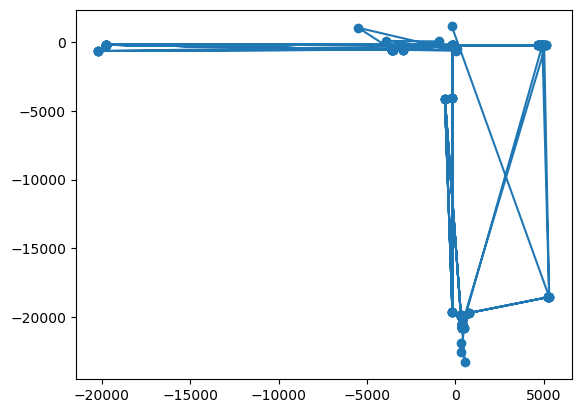

In [6]:
import matplotlib.pyplot as plt

plt.plot(X, Y, '-o')

## Identify the optics

In [7]:
# optic key: [common optic name, zemax optic name]
optics = {
    'ITMX': ['ITMX', 'ITMX_RADIUS'],
    'ITMY': ['ITMY', 'ITMY_RADIUS'],
    'BS': ['BS', 'BS'],
    'SR3': ['SR3', 'SR3_RADIUS'],
    'SR2': ['SR2', 'SR2_RADIUS'],
    'SRM': ['SRM', 'SRM'],
    'PR3': ['PR3', 'PR3_RADIUS'],
    'PR2': ['PR2', 'PR2_RADIUS'],
    'PRM': ['PRM', 'PRM_RADIUS'],
    'OM1': ['OM1', 'OM1'],
    'OM2': ['OM2', 'OM2'],
    'OM3': ['OM3', 'OM3'],
    'OMC fold': ['OMC fold', 'input mirror'],
    'OMC in': ['OMC input', 'cavity input'],
    'ZM4': ['ZM4', 'ZM4'],
    'ZM5': ['ZM5', 'ZM5'],
    'ZM6': ['ZM6', 'ZM6'],
    'SQZ Inj': ['SQZ Inj', 'SQZ Inj'],
    'SQZ TFP': ['SQZ TFP', 'Thin Film']
}

### Find the elements which match the optic names and get the coordinates of those optics (subject to discrimination)

Need to add some code that will skip an element if it can't be found

Check
- SRM
- OM1
- OMC fold
- OMC in
- ZM4


In [8]:
for zName in optics:
    print(zName)
    cSub = np.array([]).reshape((0,3))
    for ii in range(Comment.size):
        # identify elements that contain the optic name
        if Comment[ii].strip().startswith(optics[zName][1]):
            # add x,y,int data to numpy array
            cSub = np.append(cSub, [[X[ii], Y[ii], intensity[ii]]], axis=0)
    
    if cSub.size > 0:
        # locate the elements with the highest intenstiy
        maxInt = np.max(cSub[:, 2])
        a = np.argwhere(cSub[:, 2] == maxInt)
        a = a.reshape(a.size)

        # get the coordinates of the highest intensity ray
        coord = cSub[a[0], 0:2]
        # add discriminator for ITMX and ITMY
        maxInd = np.argwhere(cSub[:, 2] > 0.5*maxInt)
        maxInd = maxInd.reshape(maxInd.size)
        coordSub = cSub[maxInd, 0:2]
        if zName=='ITMX':
            # get extreme X most coordinate
            bestInd = np.argwhere(coordSub[:,0]==np.max(coordSub[:,0]))
            bestInd = bestInd.reshape(bestInd.size)[0]
            coord = cSub[bestInd, 0:2]
        if zName=='ITMY':
            # get extreme Y most coordinate
            bestInd = np.argwhere(coordSub[:,1]==np.max(coordSub[:,1]))
            bestInd = bestInd.reshape(bestInd.size)[0]
            coord = cSub[bestInd, 0:2]

        # append the coordinates to the optics list
        optics[zName] = [optics[zName], coord]

ITMX
ITMY
BS
SR3
SR2
SRM
PR3
PR2
PRM
OM1
OM2
OM3
OMC fold
OMC in
ZM4
ZM5
ZM6
SQZ Inj
SQZ TFP


In [9]:
optics

{'ITMX': [['ITMX', 'ITMX_RADIUS'], array([5012.53125  , -200.0262299])],
 'ITMY': ['ITMY', 'ITMY_RADIUS'],
 'BS': [['BS', 'BS'], array([-202.6320038, -183.8165894])],
 'SR3': [['SR3', 'SR3_RADIUS'], array([  -174.1284637, -19615.90039  ])],
 'SR2': [['SR2', 'SR2_RADIUS'], array([ -594.0888062, -4161.499512 ])],
 'SRM': [['SRM', 'SRM'], array([   305.3476563, -19874.48047  ])],
 'PR3': [['PR3', 'PR3_RADIUS'], array([-19740.       ,   -173.8858032])],
 'PR2': [['PR2', 'PR2_RADIUS'], array([-3581.299805 ,  -530.4000244])],
 'PRM': [['PRM', 'PRM_RADIUS'], array([-20189.59961  ,   -628.0117188])],
 'OM1': [['OM1', 'OM1'], array([   538.5089111, -23327.69922  ])],
 'OM2': [['OM2', 'OM2'], array([   303.9394226, -21902.10547  ])],
 'OM3': [['OM3', 'OM3'], array([   306.9205627, -22568.82813  ])],
 'OMC fold': ['OMC fold', 'input mirror'],
 'OMC in': ['OMC input', 'cavity input'],
 'ZM4': ['ZM4', 'ZM4'],
 'ZM5': [['ZM5', 'ZM5'], array([  5297.050293, -18553.10547 ])],
 'ZM6': [['ZM6', 'ZM6'], 

### Get distances between optics

In [10]:
#PL_OM1_OM2 (PL = physical length)
# SRC
distances = {
    'SR3_SR2': np.linalg.norm(optics['SR3'][1] - optics['SR2'][1]),
    'SR2_SRM': np.linalg.norm(optics['SR2'][1] - optics['SRM'][1]),
    # Output chain
    'SRM_OM1': np.linalg.norm(optics['SRM'][1] - optics['OM1'][1]),
    'OM1_OM2': np.linalg.norm(optics['OM1'][1] - optics['OM2'][1]),
    'OM2_OM3': np.linalg.norm(optics['OM2'][1] - optics['OM3'][1]),
    'OM3_OMCin': 293.2 + 10.8, # from D0901822-v12 (WIP).EASM (31.5 MB) from v11 of that document
    # SQZ distances
    #'ZM4_ZM5': np.linalg.norm(optics['ZM4'][1] - optics['ZM5'][1]),
    'ZM5_ZM6': np.linalg.norm(optics['ZM5'][1] - optics['ZM6'][1]),
    'ZM6_OFI': np.linalg.norm(optics['ZM6'][1] - optics['SQZ Inj'][1]) +  np.linalg.norm(optics['SQZ TFP'][1] - optics['SQZ Inj'][1]),
    'OFI_SRM': np.linalg.norm(optics['SQZ TFP'][1] - optics['SRM'][1]),
}
#arr = np.round([PL_SR3_SR2, PL_SR2_SRM, PL_SRM_OM1, PL_OM1_OM2, PL_OM2_OM3, PL_OM3_OMC, PL_ZM4_ZM5, PL_ZM5_ZM6, PL_ZM6_OFI, PL_OFI_SRM])
#print(arr)
for dName in distances:
    distances[dName] = [distances[dName], distances[dName]]

# refractive index of glass
n = 1.45

# transmissive optics on HAM5
thkSRM = 100 # mm
thkTFP = 10 # mm
distances['SRM_OM1'][1] = distances['SRM_OM1'][1] + (n-1)*thkSRM + (n-1)*thkTFP
distances['OFI_SRM'][1] = distances['OFI_SRM'][1] + (n-1)*thkSRM

# transmissive optics on HAM6
thkOMCin = 10 #mm
distances['OM3_OMCin'][1] = distances['OM3_OMCin'][1] + (n-1)*thkOMCin



In [11]:
distances['SRM_OM1']

[3461.0813203522785, 3510.5813203522785]

## Generate a LaTeX file

In [12]:
from datetime import datetime
now = datetime.now()
dateNow = now.strftime('%d/%b/%Y')

In [13]:
DCCnum = 'E2100383-v4'
fname = IFOname + '_coords_' + DCCnum + '.tex'
with open(fname, 'w') as f:
    # header information
    f.write('\\documentclass{article}\n')
    f.write('\\usepackage{graphicx} % Required for inserting images \n')
    f.write('\\usepackage{hyperref} \n')
    f.write('\\title{Table ' + IFOname + '} \n')
    f.write('\\author{ZEMAX 2 PDF }\n')
    f.write('\\date{' + dateNow + '}\n\n')
    f.write('\\begin{document}\n')
    f.write('\\maketitle\n\n\n')

    f.write('Data extracted from Ray Database file in ' + DCCnum + ' at \\url{https://dcc.ligo.org/LIGO-' + DCCnum + '}\n')
    f.write('\n\n {\\bf Notes: }\n')
    f.write('\\begin{itemize} \n')
    f.write('\\item OM3 to OMCin was measured directly off  D0901822-v12 (WIP).EASM (31.5 MB) model in D0901822-v11:\n')
    f.write('\\end{itemize}\n\n')
    f.write('\n\n Regarding optical distances:\n')
    f.write('\\begin{itemize} \n \\item SQZ thin film polarizer assumed to be fused silica and ' + '{0:.0f}'.format(thkTFP) + 'mm thick\n')
    f.write(' \\item OMC input assumed to be fused silica and ' + '{0:.0f}'.format(thkOMCin) + 'mm thick\n')
    f.write('\\end{itemize}\n\n')

    f.write('\\begin{table}[h!] \n\\centering \n\\begin{tabular}{| c| c | c |} \n')
    f.write('\\hline \\bf{Optic name} & \\bf{Global X coord (mm)} & \\bf{Global Y coord (mm)} \\\\ \\hline \n')


    # loop through all the elements
    for zName in optics:
        coords = optics[zName][1]
        if type(coords) == np.ndarray:
            strOut = zName + ' & ' + '{0:.0f}'.format(coords[0]) + ' & ' + '{0:.0f}'.format(coords[1]) + '\\\\ \n'
            f.write(strOut)
    
    f.write('\\hline \n\\end{tabular} \n')
    f.write('\\caption{Table of physical ' + IFOname + ' coordinates derived from ZEMAX. Generated on ' + dateNow + '}\n')
    f.write('\\end{table} \n')

    f.write('\n')

    # get the table of distances between optics
    f.write('\\begin{table}[h!] \n\\centering  \n\\begin{tabular}{| c| c | c |} \n')
    f.write('\\hline \\bf{Distance} & \\bf{Physical Length (mm)} & \\bf{Optical Length (mm)} \\\\ \\hline \n')

    # loop through all the elements
    for dName in distances:
        PL = distances[dName][0]
        OL = distances[dName][1]

        strOut = dName.replace('_', '\_') + ' & ' + '{0:.0f}'.format(PL) + ' & ' + '{0:.0f}'.format(OL) + '\\\\ \n'
        f.write(strOut)
    
    f.write('\\hline \n\\end{tabular} \n')
    f.write('\\caption{Table of ' + IFOname + ' distances derived from ZEMAX. Generated on ' + dateNow + '}\n')
    f.write('\\end{table} \n')
    f.write('\n\n Generated by \\url{https://git.ligo.org/IFOsim/ligo-commissioning-modeling/-/tree/main/ZEMAX/' + IFOname + '_zemax2pdf.ipynb}\n\n')
    f.write('\n\n\\end{document}')

## Generate a PDF

In [14]:
import os

os.system('pdflatex ' + fname)
os.system('rm *.dvi *.aux *.log *.out')

This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016/MacPorts 2016_4) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./LHO_coords_E2100383-v4.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 3 language(s) loaded.
(/opt/local/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/opt/local/share/texmf-texlive/tex/latex/base/size10.clo))
(/opt/local/share/texmf-texlive/tex/latex/graphics/graphicx.sty
(/opt/local/share/texmf-texlive/tex/latex/graphics/keyval.sty)
(/opt/local/share/texmf-texlive/tex/latex/graphics/graphics.sty
(/opt/local/share/texmf-texlive/tex/latex/graphics/trig.sty)
(/opt/local/share/texmf-texlive/tex/latex/graphics-cfg/graphics.cfg)
(/opt/local/share/texmf-texlive/tex/latex/pdftex-def/pdftex.def
(/opt/local/share/texmf-texlive/tex/generic/oberdiek/infwarerr.sty)
(/opt/local/share/texmf-texlive/tex/generic/oberdiek/ltxcmds.sty))))
(/opt/local/s

rm: *.dvi: No such file or directory


256